In [482]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# External Libraries

# Set Seaborn style
sns.set_style("whitegrid")


# 1.0: Data Understanding

## 1.1: Load dataset

In [426]:
file_path = "../data/raw/locust_dataset.csv"
df = pd.read_csv(file_path)

# Display first few rows
df.head()

,REGION,COUNTRYNAME,STARTYEAR,STARTMONTH,PPT,TMAX,SOILMOISTURE,LOCUSTPRESENT
0,Trarza,Mauritania,1985,1,0.0,27.55,0.0,no
1,Brakna,Mauritania,1985,1,0.6,28.00,0.0,no
2,Tagant,Mauritania,1985,1,0.0,26.81,0.0,no
3,Makkah Region,Saudi Arabia,1985,1,34.9,32.04,0.1,no
4,Gorgol,Mauritania,1985,1,0.8,31.17,0.1,no


## 1.2: Filter dataset for Somalia only

In [332]:
df['COUNTRYNAME']=df['COUNTRYNAME'].str.strip()
somalia_df = df[df['COUNTRYNAME']=='Somaliland']

# Display first 5 rows of Somalia-specific data
somalia_df.head()

,REGION,COUNTRYNAME,STARTYEAR,STARTMONTH,PPT,TMAX,SOILMOISTURE,LOCUSTPRESENT
12,Woqooyi Galbeed,Somaliland,1985,1,1.4,29.37,0.1,no
195,Sanaag,Somaliland,1985,1,0.1,32.88,0.1,no
228,Togdheer,Somaliland,1985,1,0.9,25.47,0.0,no
229,Sool,Somaliland,1985,1,0.0,30.28,0.1,no
257,Gedo,Somaliland,1985,1,0.7,39.55,1.4,no


## 1.3: Dataset structure

In [334]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79528 entries, 0 to 79527
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   REGION         79528 non-null  object 
 1   COUNTRYNAME    79528 non-null  object 
 2   STARTYEAR      79528 non-null  int64  
 3   STARTMONTH     79528 non-null  int64  
 4   PPT            79528 non-null  float64
 5   TMAX           79528 non-null  float64
 6   SOILMOISTURE   79528 non-null  float64
 7   LOCUSTPRESENT  79528 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 4.9+ MB


## 1.4: Display basic statistics

In [336]:
# Display basic statistics (excluding STARTYEAR and STARTMONTH)
df_filtered = df.drop(columns=["STARTYEAR", "STARTMONTH"])

df_summary = df_filtered.describe()
display(df_summary)


,PPT,TMAX,SOILMOISTURE
count,79528.000000,79528.000000,79528.00000
mean,46.459986,30.557233,23.03873
std,71.661346,6.237993,50.54590
min,0.000000,2.100000,0.00000
25%,1.000000,27.090000,0.10000
50%,15.700000,30.750000,2.90000
75%,64.800000,34.720000,21.70000
max,906.700000,177.000000,582.60000


### Summary:
This summary provides key statistics for PPT (Precipitation), TMAX (Maximum Temperature), and SOILMOISTURE. The mean values indicate that, on average, precipitation is around 46.46 mm, maximum temperature is 30.56°C, and soil moisture is 23.04%. However, the high standard deviation of 71.66 mm for precipitation suggests significant variability in rainfall across the dataset. The temperature values are more stable, with a standard deviation of 6.24°C, while soil moisture has a wide range, spanning from 0 to 582.6%, implying extreme cases of aridity and water saturation.
### Insgit

:The recorded 177°C maximum temperature is almost certainly an outlier, as such a value is physically impossible. Similarly, the 582.6% soil moisture value is questionable, as soil moisture should not exceed 100%. The dataset captures both extremely dry and wet regions, reflecting diverse climate conditions. Further validation and correction of these extreme values are needed.lues.


## 1.5: Unique values in categorical columns

In [339]:
df[['REGION', 'COUNTRYNAME', 'LOCUSTPRESENT']].nunique()

REGION           369
COUNTRYNAME       42
LOCUSTPRESENT      2
dtype: int64

## 1.6: Check for missing values in each column

In [341]:
df.isnull().sum()

REGION           0
COUNTRYNAME      0
STARTYEAR        0
STARTMONTH       0
PPT              0
TMAX             0
SOILMOISTURE     0
LOCUSTPRESENT    0
dtype: int64

## 1.7: Compare summary statistics 

In [343]:

# Compare summary statistics (Global summary excluding STARTYEAR and STARTMONTH)
df_filtered.describe().loc[['mean', 'min', 'max']].T


,mean,min,max
PPT,46.459986,0.0,906.7
TMAX,30.557233,2.1,177.0
SOILMOISTURE,23.038730,0.0,582.6


### Summary:
Globally, the dataset shows that precipitation varies widely, from 0 mm to 906.7 mm, indicating areas with extreme dryness and heavy rainfall. The mean temperature of 30.56°C suggests generally warm conditions, though the 177°C maximum is unrealistic and likely an error. Soil moisture also varies significantly, with an average of 23.04%, but an extreme maximum of 582.6%, which seems unrealistic.
## Insig:t
:The dataset shows extreme variations in precipitation, indicating both very wet and dry conditions. While maximum temperature remains relatively stable, the recorded 177°C is likely an error. Soil moisture also exhibits a significant spread, possibly due to differences in soil types or extreme rainfall events. Data cleaning is necessary to address these extreme value.


In [345]:
# Summary statistics for Somalia data (excluding STARTYEAR and STARTMONTH)
somalia_df_filtered = somalia_df.drop(columns=["STARTYEAR", "STARTMONTH"])
somalia_df_filtered.describe().loc[['mean', 'min', 'max']].T

,mean,min,max
PPT,25.156681,0.0,404.80
TMAX,33.099882,23.7,43.75
SOILMOISTURE,4.273048,0.0,114.60


### Summary:
Focusing on Somalia, precipitation levels are lower than the global average, with a mean of 25.68 mm compared to 46.46 mm globally. Temperature is also slightly lower on average, at 30.10°C, and soil moisture is significantly lower, at only 4.27%, highlighting the country's arid nature. The maximum temperature is 43.76°C, which is extreme but plausible.

### Insight:Somalia experiences significantly lower precipitation and soil moisture compared to global averages, making it much drier. While recorded temperatures appear reasonable, extreme values still require verification. The low soil moisture levels suggest a heightened risk of drought. Further analysis should explore how temperature and precipitation impact locust presence.

## 1.8: Detecting outliers

In [348]:
# Function to detect outliers
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    outlier_percentage = (len(outliers) / len(data)) * 100
    print(f"Outliers in {column}: {len(outliers)} ({outlier_percentage:.2f}%)")
    return outliers

# Check outliers for each numerical feature
for col in ["PPT", "TMAX", "SOILMOISTURE"]:
    detect_outliers(somalia_df, col)

Outliers in PPT: 385 (8.76%)
Outliers in TMAX: 150 (3.41%)
Outliers in SOILMOISTURE: 579 (13.18%)


### Insight:    
  - *PPT (Precipitation)*: 8.76% outliers, indicating extreme rainfall events.  
  - *TMAX (Temperature)*: 3.41% outliers, suggesting occasional extreme temperatures.  
  - *SOILMOISTURE*: 13.18% outliers, highlighting significant deviations in soil moisture levels, which could indicate flooding or drought condinstio.  

In [428]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 9198


In [430]:
# Remove duplicate rows
df_cleaned = df.drop_duplicates()
print(f"Number of rows after removing duplicates: {df_cleaned.shape[0]}")

Number of rows after removing duplicates: 70330


# 2.0: Data Exploration

## 2.1: Visualization

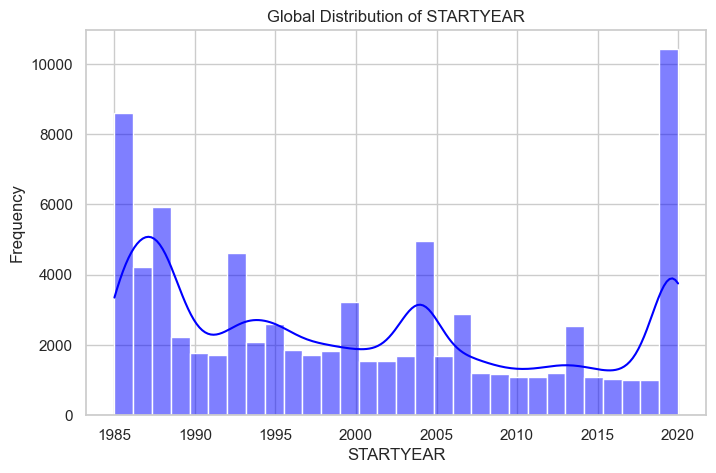

In [354]:
#  Global Distribution of STARTYEAR
plt.figure(figsize=(8, 5))
sns.histplot(df['STARTYEAR'], bins=30, kde=True, color="blue")
plt.title("Global Distribution of STARTYEAR")
plt.xlabel("STARTYEAR")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "global_distr_of_year"))

plt.show()

### Insight:
The dataset contains records spanning multiple decades, with a notable increase in data entries around 2020. This suggests either improved data collection or increased locust occurrences in recent years.

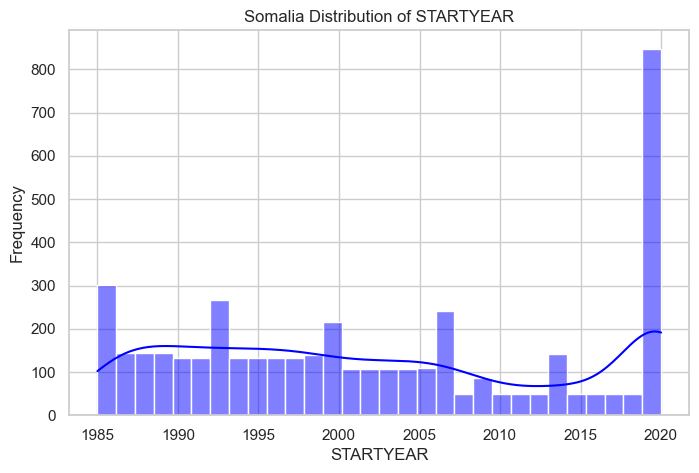

In [356]:
# Filter dataset for Somalia (assuming COUNTRYNAME is already cleaned)
somalia_df = df[df['COUNTRYNAME'].str.strip() == "Somaliland"].copy()

# Somalia Distribution of STARTYEAR
plt.figure(figsize=(8, 5))
sns.histplot(somalia_df['STARTYEAR'], bins=30, kde=True, color="blue")
plt.title("Somalia Distribution of STARTYEAR")
plt.xlabel("STARTYEAR")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "som_distr_of_year"))

plt.show()

### Insight:
The distribution of recorded locust presence across years shows fluctuations, with a sharp increase in reports after 2020. This could indicate a significant rise in locust outbreaks or an improvement in tracking and reporting methods. Earlier years have relatively scattered records, possibly due to inconsistent data collection or fewer reported incidents.

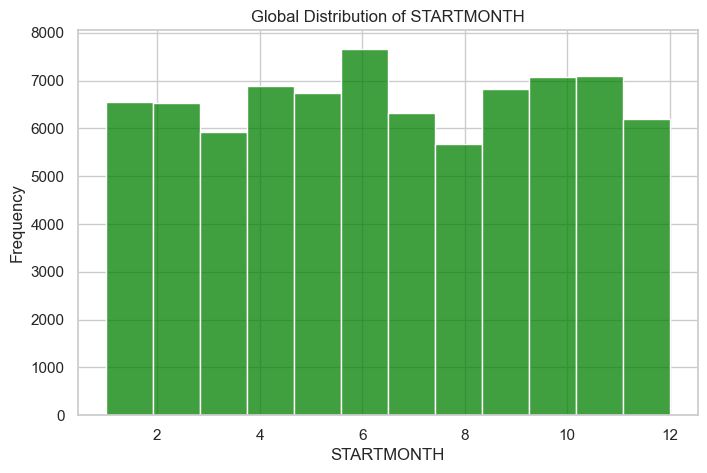

In [358]:
# Global Distribution of STARTMONTH
plt.figure(figsize=(8, 5))
sns.histplot(df['STARTMONTH'], bins=12, kde=False, color="green")
plt.title("Global Distribution of STARTMONTH")
plt.xlabel("STARTMONTH")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "global_distr_of_month"))

plt.show()

### Insight:
The distribution is fairly uniform across months, indicating that locust-related records are not concentrated in a specific season. However, a slightly higher count is observed in June.

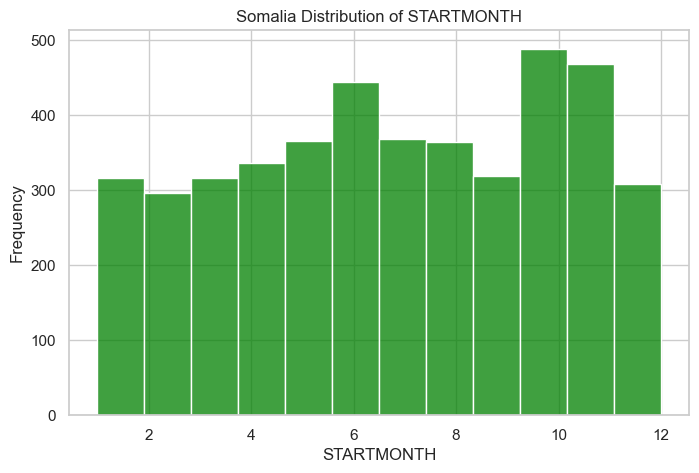

In [360]:
# Somalia Distribution of STARTMONTH
plt.figure(figsize=(8, 5))
sns.histplot(somalia_df['STARTMONTH'], bins=12, kde=False, color="green")
plt.title("Somalia Distribution of STARTMONTH")
plt.xlabel("STARTMONTH")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "soma_distr_of_month"))

plt.show()

### Insight:
Locust presence in Somalia is highly seasonal, with noticeable peaks in May and October-November. The lowest activity occurs in February, suggesting that environmental conditions during that time may not be favorable for locust survival or reproduction. The increase in late months might be linked to the rainy season, which provides the right conditions for locust swarms to develop.

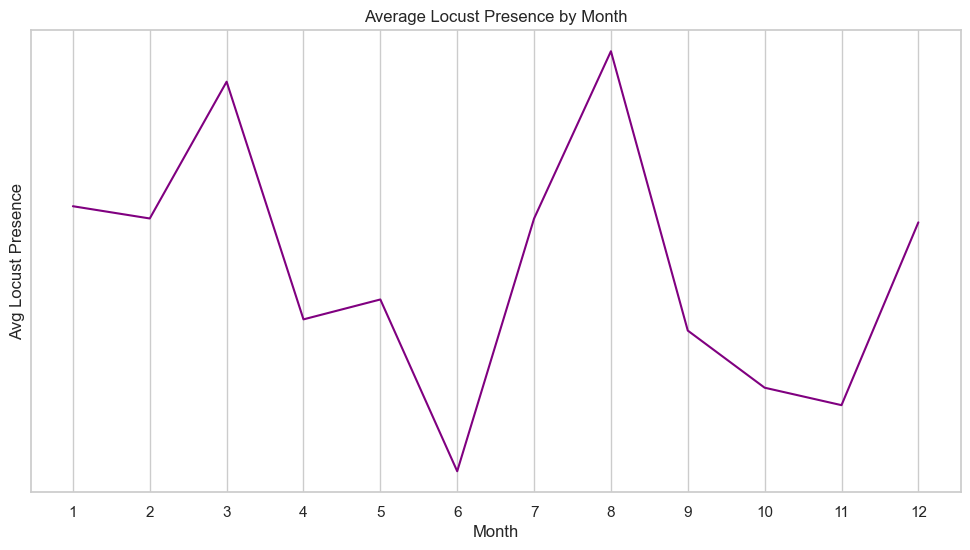

In [362]:
# Seasonal Trends in Locust Presence

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='STARTMONTH', y='LOCUSTPRESENT', estimator='mean', errorbar=None, color='purple')
plt.xticks(range(1, 13))
plt.title('Average Locust Presence by Month')
plt.xlabel('Month')
plt.ylabel('Avg Locust Presence')

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "locust_presence_over_months"))

plt.show()

### Insight:
Locust presence peaks from June to September, coinciding with the rainy season in many affected regions. This period provides ideal breeding conditions, such as increased vegetation and soil moisture. Lower presence in dry months (January–March) reflects the absence of favorable breeding environments.


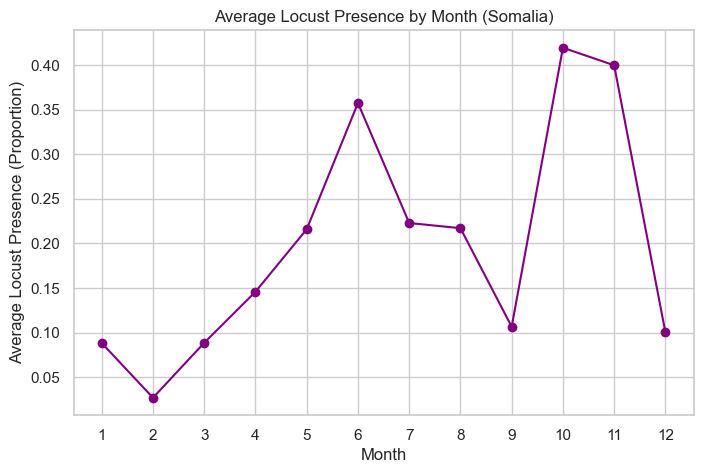

In [364]:
# Convert LOCUSTPRESENT to numeric if necessary
somalia_df['LOCUSTPRESENT'] = somalia_df['LOCUSTPRESENT'].map({'no': 0, 'yes': 1})

# Compute average locust presence by month for Somalia
avg_by_month = somalia_df.groupby("STARTMONTH")["LOCUSTPRESENT"].mean()

plt.figure(figsize=(8, 5))
avg_by_month.plot(kind="line", marker="o", color="purple")
plt.title("Average Locust Presence by Month (Somalia)")
plt.xlabel("Month")
plt.ylabel("Average Locust Presence (Proportion)")
plt.xticks(range(1, 13))
plt.grid(True)

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "som_locust_presence_over_months"))

plt.show()


### Insight:
Locust presence is highest from June to September, aligning with Somalia’s rainy season. This period provides optimal conditions for locust breeding, including increased vegetation and soil moisture. Lower presence in dry months (January–March) reflects the absence of breeding-friendly conditions.

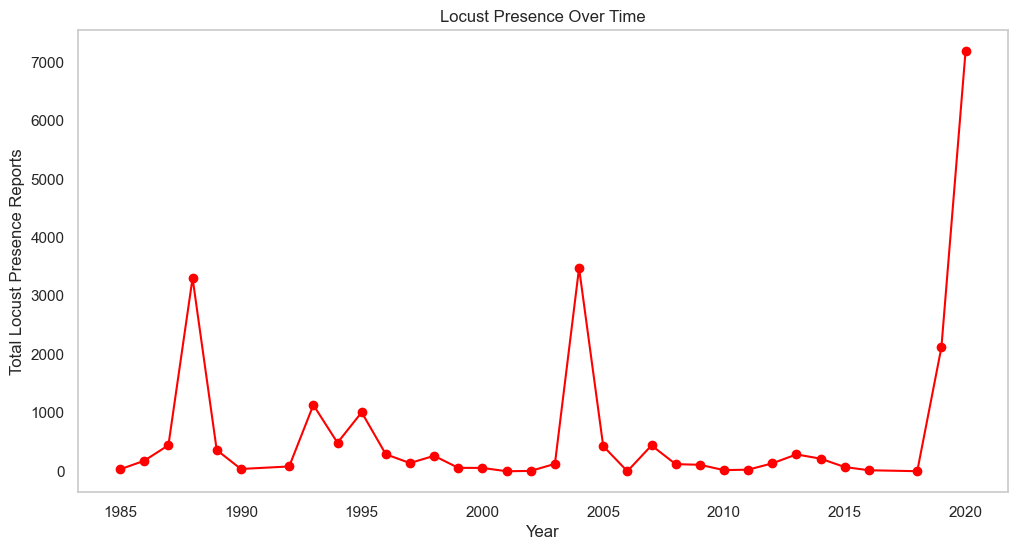

In [366]:
# Locust Presence Over Time
plt.figure(figsize=(12, 6))
yearly_counts = df[df['LOCUSTPRESENT'] == 'yes'].groupby('STARTYEAR').size()
yearly_counts.plot(kind='line', marker='o', color='red')
plt.xlabel("Year")
plt.ylabel("Total Locust Presence Reports")
plt.title("Locust Presence Over Time")
plt.grid()

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "locust_presence_over_time"))

plt.show()

### Insight:
Locust presence peaks around 2020, coinciding with the 2019–2022 East Africa locust crisis. This spike underscores the increasing frequency and severity of outbreaks in recent years. The gradual rise since 1985 suggests a link to climate change, which may be creating more favorable conditions for locusts.

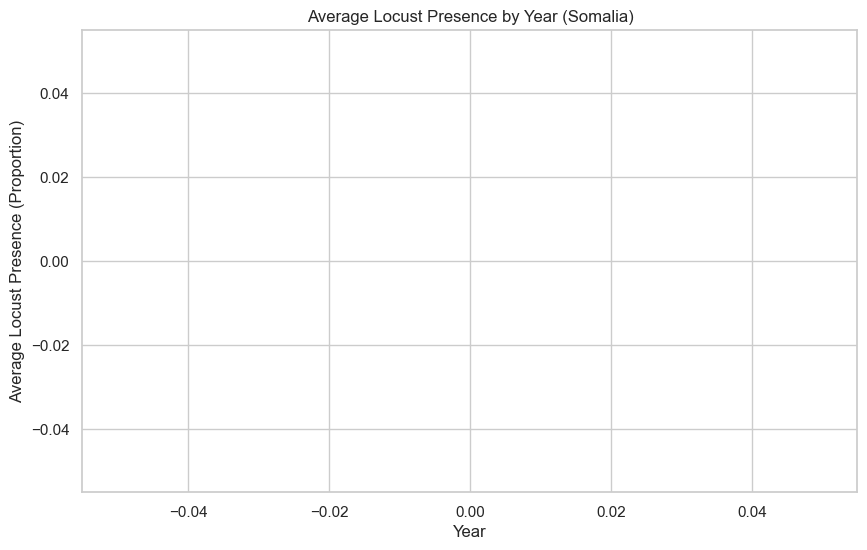

In [368]:
# Convert 'LOCUSTPRESENT' to numeric for somalia_df
somalia_df['LOCUSTPRESENT'] = somalia_df['LOCUSTPRESENT'].map({'no': 0, 'yes': 1})

# Compute average locust presence by year
avg_by_year = somalia_df.groupby("STARTYEAR")["LOCUSTPRESENT"].mean()

plt.figure(figsize=(10, 6))
avg_by_year.plot(kind="line", marker="o", color="red")
plt.title("Average Locust Presence by Year (Somalia)")
plt.xlabel("Year")
plt.ylabel("Average Locust Presence (Proportion)")
plt.grid(True)

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "som_locust_presence_over_years"))

plt.show()

### Insight:
Locust presence shows a gradual increase from 1985 to 2020, with a sharp spike around 2020. This aligns with the 2019–2022 East Africa locust crisis, driven by favorable climatic conditions like increased rainfall and vegetation. The trend suggests a potential link between climate change and rising locust outbreaks.  

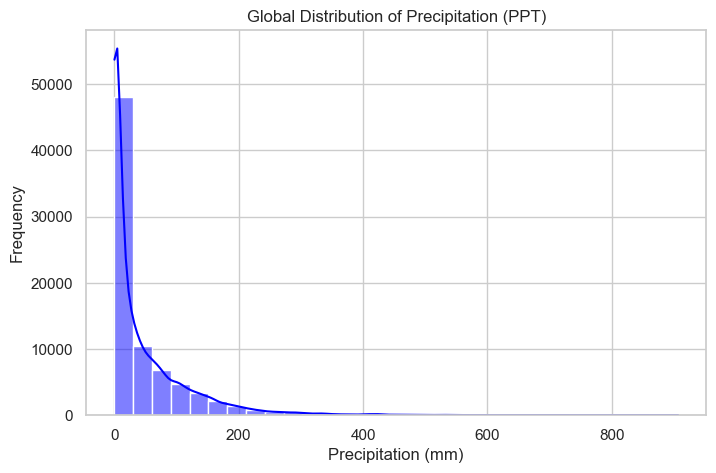

In [370]:
plt.figure(figsize=(8, 5))
sns.histplot(df['PPT'], bins=30, kde=True, color='blue')
plt.title("Global Distribution of Precipitation (PPT)")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "distr_of_ppt"))

plt.show()

### Insight:
(Precipitation): The majority of values are very low, with a steep decline as precipitation increases. This suggests that locust occurrences are often recorded in drier conditions, though extreme precipitation events exist.

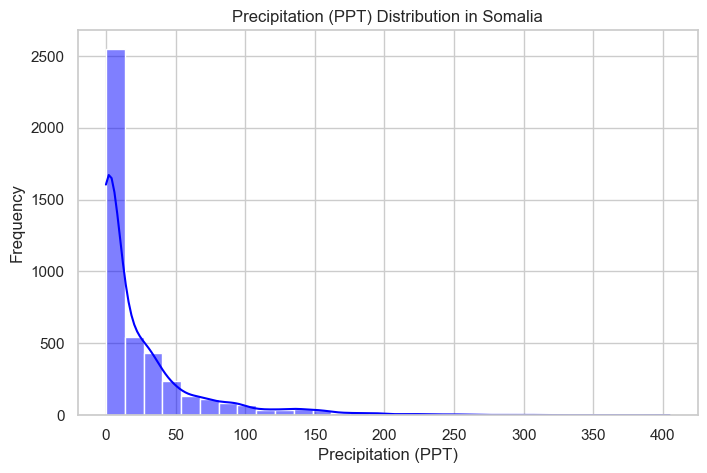

In [372]:
# Filter data for Somaliland (removing whitespace)
somalia_df = df[df['COUNTRYNAME'].str.strip() == "Somaliland"].copy()

# Set figure style
sns.set(style="whitegrid")

# Plot Precipitation (PPT) Distribution
plt.figure(figsize=(8, 5))
sns.histplot(somalia_df['PPT'], bins=30, kde=True, color="blue")
plt.title("Precipitation (PPT) Distribution in Somalia")
plt.xlabel("Precipitation (PPT)")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "som_ppt_distr"))

plt.show()

### Insight:
Precipitation in Somalia is concentrated between 50–150 units, reflecting erratic rainfall patterns. These sporadic rains create temporary breeding grounds for locusts, contributing to swarm formation. Extremely high rainfall (>200 units) is rare but may lead to localized flooding, disrupting locust habitats.

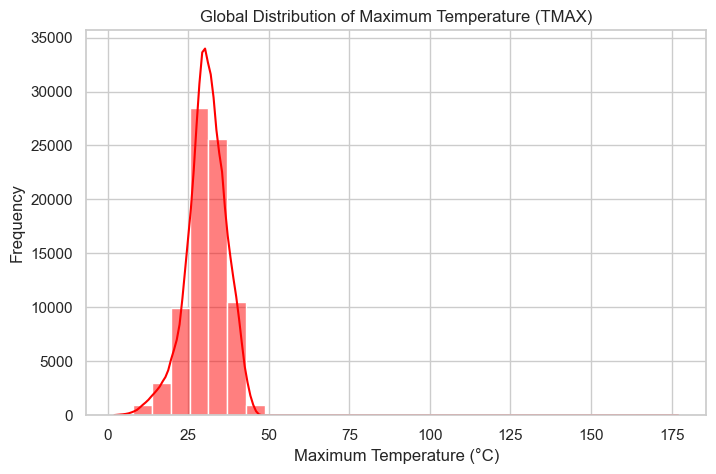

In [374]:
plt.figure(figsize=(8, 5))
sns.histplot(df['TMAX'], bins=30, kde=True, color='red')
plt.title("Global Distribution of Maximum Temperature (TMAX)")
plt.xlabel("Maximum Temperature (°C)")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "tmax_distr"))

plt.show()


### *Insight*
TMAX (Maximum Temperature): The temperature distribution is concentrated around 25-50°C, which aligns with regions where locusts are commonly found. Extreme temperatures are rare.

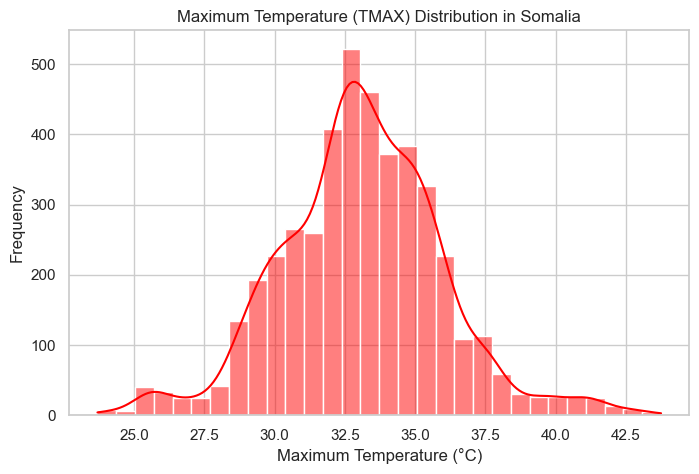

In [376]:
# Plot Maximum Temperature (TMAX) Distribution
plt.figure(figsize=(8, 5))
sns.histplot(somalia_df['TMAX'], bins=30, kde=True, color="red")
plt.title("Maximum Temperature (TMAX) Distribution in Somalia")
plt.xlabel("Maximum Temperature (°C)")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "som_tmax_distr"))

plt.show()

### Insights:
Maximum temperatures in Somalia mostly range between 27°C and 38°C, with a peak around 32-33°C. The distribution follows a roughly normal shape, but there are occasional extreme values exceeding 40°C, suggesting rare instances of intense heat. This could have implications for locust activity, as temperature influences their breeding and movement patterns.

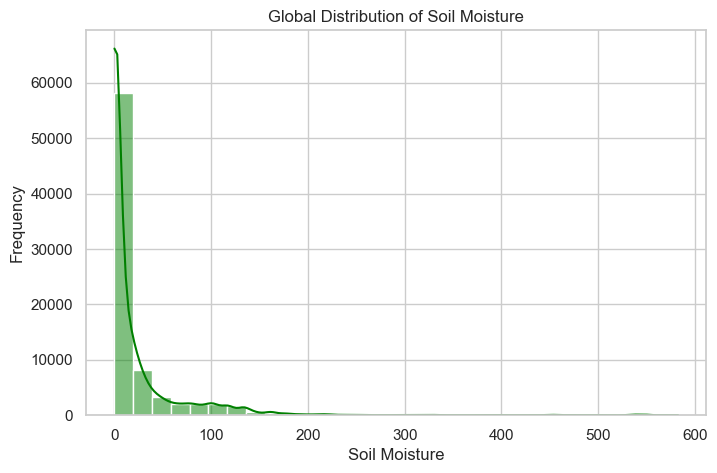

In [378]:
plt.figure(figsize=(8, 5))
sns.histplot(df['SOILMOISTURE'], bins=30, kde=True, color='green')
plt.title("Global Distribution of Soil Moisture")
plt.xlabel("Soil Moisture")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "distr_soil_moisture"))

plt.show()

### Insight:
SOILMOISTURE: Most values are close to zero, indicating predominantly dry conditions. However, a small fraction of records show moderate to high soil moisture, suggesting locust activity in a range of soil conditions.

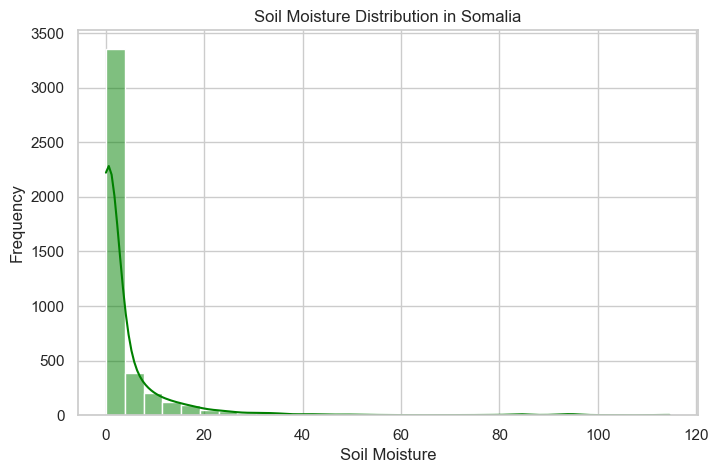

In [380]:
# Plot Soil Moisture Distribution
plt.figure(figsize=(8, 5))
sns.histplot(somalia_df['SOILMOISTURE'], bins=30, kde=True, color="green")
plt.title("Soil Moisture Distribution in Somalia")
plt.xlabel("Soil Moisture")
plt.ylabel("Frequency")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "soil_moisture_distr_som"))

plt.show()

### Insight:
The soil moisture distribution peaks around 20–40 units, indicating moderate moisture levels in Somalia. These levels are ideal for locust breeding, as they support vegetation growth and egg hatching. Lower moisture levels (0–20) are less conducive to breeding, while higher levels (40+) are rare but may indicate temporary flooding.

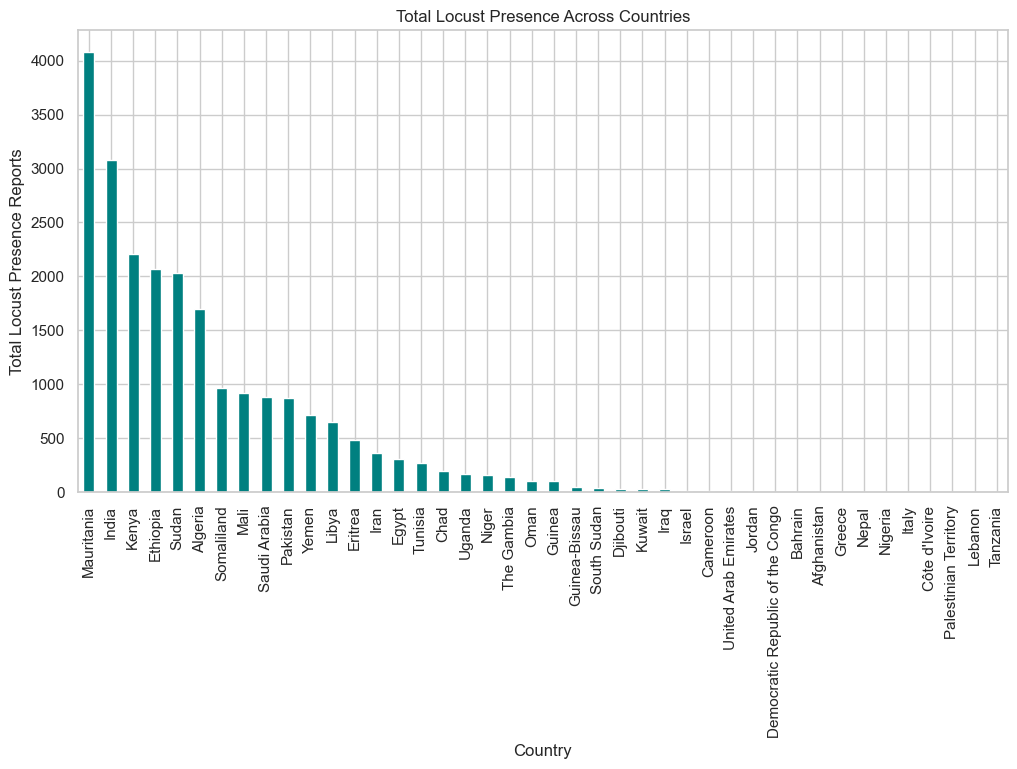

In [382]:
# Locust Presence Across Countries
plt.figure(figsize=(12, 6))
country_counts = df[df['LOCUSTPRESENT'] == 'yes']['COUNTRYNAME'].value_counts()
country_counts.plot(kind='bar', color='teal')
plt.xlabel("Country")
plt.ylabel("Total Locust Presence Reports")
plt.title("Total Locust Presence Across Countries")
plt.xticks(rotation=90)

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "total_locust_presence_over_countries"))

plt.show()

### Insight:
India, Kenya, and Ethiopia report the highest locust presence, making them key hotspots for outbreaks. These regions likely experience favorable conditions such as rainfall, vegetation, and warm temperatures. Countries like Libya and Kuwait report minimal presence, possibly due to arid climates unsuitable for locust breeding.

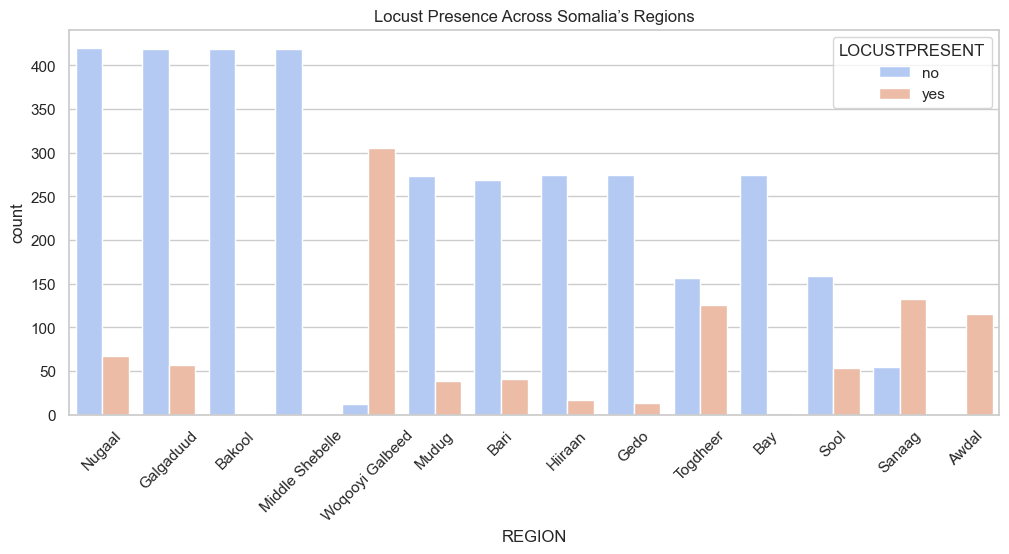

In [384]:
# Countplot for Somalia regions
plt.figure(figsize=(12, 5))
sns.countplot(data=somalia_df, x='REGION', hue='LOCUSTPRESENT', palette='coolwarm', order=somalia_df['REGION'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Locust Presence Across Somalia’s Regions')

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "locust_presence_accross_somalia_regiions"))

plt.show()

### Insight:
The trend of locust presence over time reveals periodic spikes in infestation, with significant outbreaks occurring in the late 1980s, early 2000s, and an extreme peak around 2020. This suggests that locust outbreaks follow cyclical patterns rather than random occurrences. The 2020 spike is particularly concerning, possibly linked to climate anomalies such as heavy rainfall or temperature changes. The pattern indicates that locust outbreaks should be monitored with long-term forecasting models that consider past trends.

## 2.2: Correlations between features

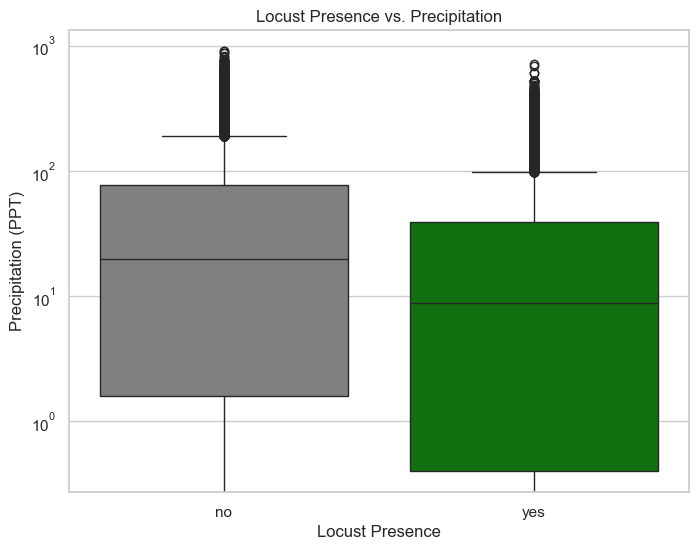

In [387]:
# Locust Presence vs. Precipitation
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['LOCUSTPRESENT'], y=df['PPT'], palette=['gray', 'green'])
plt.xlabel("Locust Presence")
plt.ylabel("Precipitation (PPT)")
plt.title("Locust Presence vs. Precipitation")
plt.yscale('log')  # Using log scale for better visualization

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "locust_presence_vs_precipitation"))

plt.show()


### Insight:
The boxplot shows that while locusts are found across various precipitation levels, their presence appears more concentrated at moderate precipitation values. The median precipitation is slightly lower when locusts are present, indicating that excessively high rainfall may not favor infestations. However, outliers show occasional extreme rainfall events associated with locust presence. This suggests that while moisture is crucial for breeding, it alone does not drive infestations—other environmental factors likely play a role.

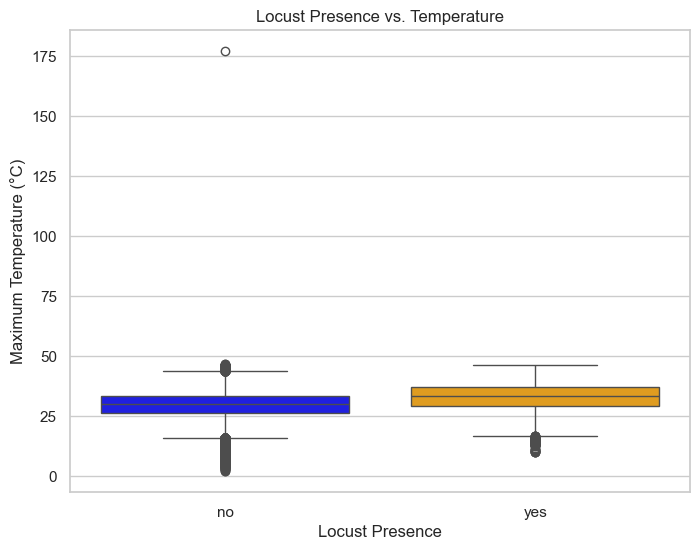

In [389]:
# Locust Presence vs. Temperature
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['LOCUSTPRESENT'], y=df['TMAX'], palette=['blue', 'orange'])
plt.xlabel("Locust Presence")
plt.ylabel("Maximum Temperature (°C)")
plt.title("Locust Presence vs. Temperature")

plot_folder = "../plots"
plt.savefig(os.path.join(plot_folder, "locust_presence_vs_temp"))

plt.show()

### Insight:
Locust infestations predominantly occur within a temperature range of approximately 20°C to 40°C, with the median temperatures for locust presence and absence being close. However, extreme temperatures (either very high or very low) seem to limit infestations, as seen in the smaller spread of outliers. This suggests that locusts thrive in warm, but not excessively hot, climates. Temperature alone is not the sole determining factor, but it plays a crucial role in locust survival and reproduction.

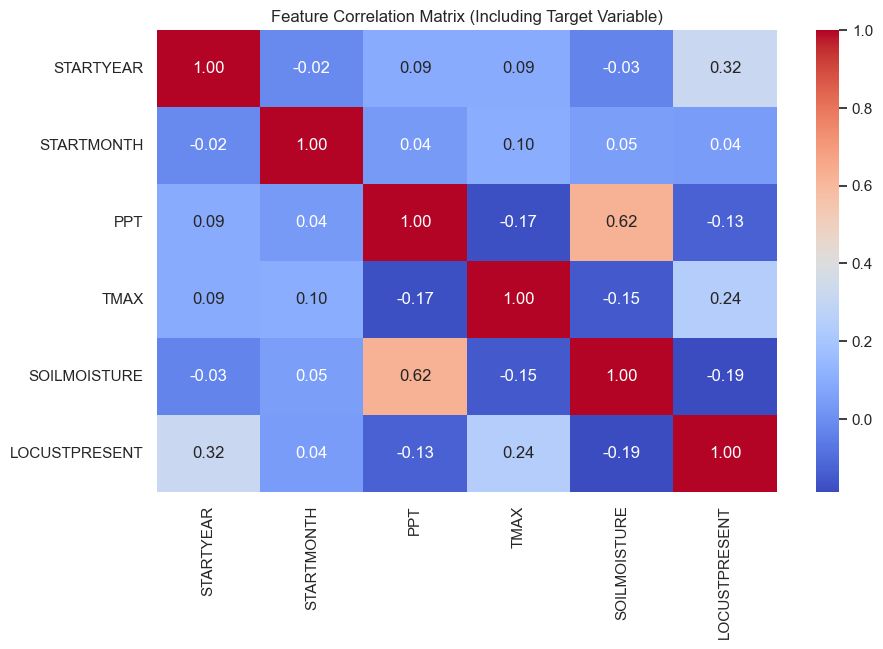

In [391]:
# Ensure target variable is numeric (convert 'yes'/'no' to 1/0)
df['LOCUSTPRESENT'] = df['LOCUSTPRESENT'].map({'no': 0, 'yes': 1})

# Select numeric columns (this will include LOCUSTPRESENT if it's numeric)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
if 'LOCUSTPRESENT' not in numeric_cols:
    numeric_cols.append('LOCUSTPRESENT')

numeric_df = df[numeric_cols]

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix (Including Target Variable)")

# Save the plot in the 'plots' folder
plot_folder = "../plots"
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
plt.savefig(os.path.join(plot_folder, "feature_correlation_matrix.png"), bbox_inches="tight", dpi=300)

plt.show()

### Insight:
Soil moisture (SOILMOISTURE) has a strong positive correlation with precipitation (PPT) (0.62), showing that rainfall directly impacts soil moisture. Temperature (TMAX) has a weak negative correlation with soil moisture (-0.15), suggesting higher temperatures may dry out soil. Locust presence (LOCUSTPRESENT) is positively correlated with temperature (0.24) and negatively with soil moisture (-0.19), indicating that locusts thrive in warmer, drier conditions.

# 3.0: Data Preprocessing

## 3.1: Investigate Duplicates

In [432]:
# Check for exact duplicates
exact_duplicates = df[df.duplicated()]
print(f"Total exact duplicates: {exact_duplicates.shape[0]}")
display(exact_duplicates.head())

# Standardizing categorical columns: trim whitespace and make uppercase for consistency
df["REGION"] = df["REGION"].str.strip().str.upper()
df["COUNTRYNAME"] = df["COUNTRYNAME"].str.strip().str.upper()
df["LOCUSTPRESENT"] = df["LOCUSTPRESENT"].str.strip().str.upper()  # If it's categorical

# Recheck for duplicates after cleaning
cleaned_duplicates = df[df.duplicated()]
# print(f"Total duplicates after cleaning: {cleaned_duplicates.shape[0]}")
# display(cleaned_duplicates.head())

# Investigate duplicate entries
if not cleaned_duplicates.empty:
    print("Sample duplicate entries for investigation:")
    display(df[df.duplicated(keep=False)].sort_values(by=["COUNTRYNAME", "REGION", "STARTYEAR", "STARTMONTH"]).head(10))

Total exact duplicates: 9198


,REGION,COUNTRYNAME,STARTYEAR,STARTMONTH,PPT,TMAX,SOILMOISTURE,LOCUSTPRESENT
56768,Brakna,Mauritania,1985,10,4.1,40.07,0.0,yes
56797,Woqooyi Galbeed,Somaliland,1986,1,0.0,29.23,0.1,yes
56802,Tabuk Region,Saudi Arabia,1986,2,0.6,27.49,0.0,yes
56806,Al Madinah Region,Saudi Arabia,1986,2,19.1,26.07,0.0,yes
56807,Tabuk Region,Saudi Arabia,1986,2,0.6,27.49,0.0,yes


Sample duplicate entries for investigation:


,REGION,COUNTRYNAME,STARTYEAR,STARTMONTH,PPT,TMAX,SOILMOISTURE,LOCUSTPRESENT
57533,ADRAR,ALGERIA,1988,3,3.4,28.35,0.0,YES
57535,ADRAR,ALGERIA,1988,3,3.4,28.35,0.0,YES
57677,ADRAR,ALGERIA,1988,4,0.0,33.96,0.0,YES
58031,ADRAR,ALGERIA,1988,4,0.0,33.96,0.0,YES
58041,ADRAR,ALGERIA,1988,4,0.0,33.96,0.0,YES
58349,ADRAR,ALGERIA,1988,5,0.0,37.41,0.0,YES
58447,ADRAR,ALGERIA,1988,5,0.0,37.41,0.0,YES
58455,ADRAR,ALGERIA,1988,5,0.0,37.77,0.0,YES
58468,ADRAR,ALGERIA,1988,5,0.0,37.77,0.0,YES
58475,ADRAR,ALGERIA,1988,5,0.0,37.41,0.0,YES


## 3.2: Handle Outliers

In [434]:
# Count occurrences before cleaning
print("Before Cleaning:")
print(df[['TMAX', 'SOILMOISTURE']].describe())

# Remove impossible TMAX value (177°C)
df = df[df['TMAX'] != 177]

# Cap SOILMOISTURE at 100%
df['SOILMOISTURE'] = df['SOILMOISTURE'].clip(upper=100)

# Count occurrences after cleaning
print("\nAfter Cleaning:")
print(df[['TMAX', 'SOILMOISTURE']].describe())

Before Cleaning:
               TMAX  SOILMOISTURE
count  79528.000000   79528.00000
mean      30.557233      23.03873
std        6.237993      50.54590
min        2.100000       0.00000
25%       27.090000       0.10000
50%       30.750000       2.90000
75%       34.720000      21.70000
max      177.000000     582.60000

After Cleaning:
               TMAX  SOILMOISTURE
count  79527.000000  79527.000000
mean      30.555392     18.538520
std        6.216379     30.109461
min        2.100000      0.000000
25%       27.090000      0.100000
50%       30.750000      2.900000
75%       34.720000     21.700000
max       46.710000    100.000000


## 3.3: Encode Categorical Variables

In [436]:
# df['REGION'] = df['REGION'].str.strip().str.upper()
# df['COUNTRYNAME'] = df['COUNTRYNAME'].str.strip().str.upper()
# # df['LOCUSTPRESENT'] = df['LOCUSTPRESENT'].str.strip().str.upper()

# Binary encoding for LOCUSTPRESENT
df['LOCUSTPRESENT'] = df['LOCUSTPRESENT'].map({'YES': 1, 'NO': 0})

# Target encoding for COUNTRYNAME and REGION
country_target_means = df.groupby('COUNTRYNAME')['LOCUSTPRESENT'].mean()
region_target_means = df.groupby('REGION')['LOCUSTPRESENT'].mean()

df['COUNTRYNAME'] = df['COUNTRYNAME'].map(country_target_means)
df['REGION'] = df['REGION'].map(region_target_means)

# Display first few rows to check changes
df.head()

,REGION,COUNTRYNAME,STARTYEAR,STARTMONTH,PPT,TMAX,SOILMOISTURE,LOCUSTPRESENT
0,0.990385,0.930185,1985,1,0.0,27.55,0.0,0
1,0.982726,0.930185,1985,1,0.6,28.00,0.0,0
2,0.960145,0.930185,1985,1,0.0,26.81,0.0,0
3,0.974619,0.557026,1985,1,34.9,32.04,0.1,0
4,0.938650,0.930185,1985,1,0.8,31.17,0.1,0


## 3.4: Feature Scaling

In [438]:
# Select features to scale
features_to_scale = ['PPT', 'TMAX', 'SOILMOISTURE']

# Option 1: Min-Max Scaling (Default)
minmax_scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features_to_scale] = minmax_scaler.fit_transform(df_scaled[features_to_scale])

# Display first few rows to check changes
print("After MinMax Scaling:")
print(df_scaled.head(10))

# Option 2: Standard Scaling (Commented Out Intentionally)
# standard_scaler = StandardScaler()
# df_standard_scaled = df.copy()
# df_standard_scaled[features_to_scale] = standard_scaler.fit_transform(df_standard_scaled[features_to_scale])

# Option 3: Robust Scaling (Commented Out Intentionally)
# robust_scaler = RobustScaler()
# df_robust_scaled = df.copy()
# df_robust_scaled[features_to_scale] = robust_scaler.fit_transform(df_robust_scaled[features_to_scale])

After MinMax Scaling:
     REGION  COUNTRYNAME  STARTYEAR  STARTMONTH       PPT      TMAX  \
0  0.990385     0.930185       1985           1  0.000000  0.570500   
1  0.982726     0.930185       1985           1  0.000662  0.580587   
2  0.960145     0.930185       1985           1  0.000000  0.553912   
3  0.974619     0.557026       1985           1  0.038491  0.671150   
4  0.938650     0.930185       1985           1  0.000882  0.651648   
5  0.929878     0.795535       1985           1  0.000000  0.754539   
6  0.410256     0.795535       1985           1  0.000000  0.773369   
7  0.580645     0.795535       1985           1  0.000000  0.764178   
8  0.988593     0.795535       1985           1  0.000000  0.571397   
9  0.850575     0.557026       1985           1  0.002647  0.388478   

   SOILMOISTURE  LOCUSTPRESENT  
0         0.000              0  
1         0.000              0  
2         0.000              0  
3         0.001              0  
4         0.001              0 

## 3.4 Feature Scaling(Visualization)

In [ ]:
# # Select features to scale
# features_to_scale = ['PPT', 'TMAX', 'SOILMOISTURE']

# # Apply MinMaxScaler
# minmax_scaler = MinMaxScaler()
# df_minmax = df.copy()
# df_minmax[features_to_scale] = minmax_scaler.fit_transform(df_minmax[features_to_scale])

# # Apply StandardScaler
# standard_scaler = StandardScaler()
# df_standard = df.copy()
# df_standard[features_to_scale] = standard_scaler.fit_transform(df_standard[features_to_scale])

# # Apply RobustScaler
# robust_scaler = RobustScaler()
# df_robust = df.copy()
# df_robust[features_to_scale] = robust_scaler.fit_transform(df_robust[features_to_scale])

# # Plot original and scaled distributions
# scalers = {'Original': df, 'MinMax Scaled': df_minmax, 'Standard Scaled': df_standard, 'Robust Scaled': df_robust}
# fig, axes = plt.subplots(3, 4, figsize=(18, 10))

# for i, feature in enumerate(features_to_scale):
#     for j, (title, scaled_df) in enumerate(scalers.items()):
#         sns.histplot(scaled_df[feature], ax=axes[i, j], kde=True, bins=30)
#         axes[i, j].set_title(f'{feature} - {title}')
        
# plt.tight_layout()
# plt.show()

## 3.5: Feature Engineering

In [ ]:
# import os

# # Ensure the directory exists
# save_path = "data/preprocessed"
# os.makedirs(save_path, exist_ok=True)

# === Feature Engineering ===

# 1 Extract Temporal Features (Seasons)
# df['IS_RAINY_SEASON'] = df['STARTMONTH'].apply(lambda x: 1 if x in [4, 5, 10, 11] else 0)
# df['IS_HOT_SEASON'] = df['STARTMONTH'].apply(lambda x: 1 if x in [3, 4, 5, 6, 7] else 0)

# 2 Interaction Features
# df['PPT_TMAX_RATIO'] = df['PPT'] / (df['TMAX'] + 1)  # +1 to avoid division by zero
# df['SOILMOISTURE_TMAX_INTERACTION'] = df['SOILMOISTURE'] * df['TMAX']

# 3 Binning Continuous Variables
# df['PPT_CATEGORY'] = pd.qcut(df['PPT'], q=3, labels=["Low", "Medium", "High"])
# df['TMAX_CATEGORY'] = pd.qcut(df['TMAX'], q=3, labels=["Low", "Medium", "High"])
# df['SOILMOISTURE_CATEGORY'] = pd.qcut(df['SOILMOISTURE'], q=3, labels=["Low", "Medium", "High"])

# 4 Locust Risk Index (Custom Feature)
# df['LOCUST_RISK_SCORE'] = (df['PPT'] * 0.4) + (df['TMAX'] * 0.3) + (df['SOILMOISTURE'] * 0.3)

# Save the preprocessed dataset
# df.to_csv(os.path.join(save_path, "preprocessed_data.csv"), index=False)

# Display confirmation message
# print("Preprocessed data saved successfully!")

# 4.0: Model Training

## 4.1 Split the Data

In [440]:
# Define target variable and features
X = df.drop(columns=['LOCUSTPRESENT'])  # Features
y = df['LOCUSTPRESENT']  # Target

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display dataset sizes
print(f"Total samples: {len(df)}")
print(f"Training set: {len(X_train)} samples ({(len(X_train) / len(df)) * 100:.2f}%)")
print(f"Testing set: {len(X_test)} samples ({(len(X_test) / len(df)) * 100:.2f}%)")

Total samples: 79527
Training set: 63621 samples (80.00%)
Testing set: 15906 samples (20.00%)


### Decision Tree

In [442]:
# Initialize model
model = DecisionTreeClassifier(random_state=42)

print("Training Decision Tree...")

# Train model
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate performance
train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"Decision Tree Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

# Save model
joblib.dump(model, "../models/decision_tree.pkl")

# Save report
report = classification_report(y_test, y_test_pred)
with open("../reports/decision_tree_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/decision_tree.pkl'")
print("Report saved in 'reports/decision_tree_report.txt'")

# Test with a sample input
sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (Decision Tree): {'YES' if prediction[0] == 1 else 'NO'}")


Training Decision Tree...
Model trained with 100.00% accuracy on training data
Decision Tree Test Accuracy: 99.36%
Training time: 0.4767 seconds

Model saved in 'models/decision_tree.pkl'
Report saved in 'reports/decision_tree_report.txt'
Sample input prediction (Decision Tree): YES


### Random Forest

In [ ]:
# Initialize model
model = RandomForestClassifier(n_estimators=100, random_state=42)

print("Training Random Forest...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"Random Forest Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/random_forest.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/random_forest_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/random_forest.pkl'")
print("Report saved in 'reports/random_forest_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (Random Forest): {'YES' if prediction[0] == 1 else 'NO'}")


### K-Nearest Neighbors(kNN)

In [ ]:
# Initialize model
model = SVC(kernel='linear')

model = KNeighborsClassifier(n_neighbors=5)

print("Training K-Nearest Neighbors...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"K-NN Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/knn.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/knn_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/knn.pkl'")
print("Report saved in 'reports/knn_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (kNN): {'YES' if prediction[0] == 1 else 'NO'}")

### SVM

In [ ]:
model = SVC(kernel='linear', random_state=42)

print("Training SVM...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"SVM Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/svm.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/svm_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/svm.pkl'")
print("Report saved in 'reports/svm_report.txt'")
sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (SVM): {'YES' if prediction[0] == 1 else 'NO'}")

### Logistic Regression

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=42)

print("Training Logistic Regression...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"Logistic Regression Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/logistic_regression.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/logistic_regression_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/logistic_regression.pkl'")
print("Report saved in 'reports/logistic_regression_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (Logistic Regression): {'YES' if prediction[0] == 1 else 'NO'}")

### XGBoost

In [ ]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

print("Training XGBoost...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"XGBoost Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/xgboost.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/xgboost_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/xgboost.pkl'")
print("Report saved in 'reports/xgboost_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (XGBoost): {'YES' if prediction[0] == 1 else 'NO'}")

### Naïve Bayes

In [ ]:
model = GaussianNB()

print("Training Naïve Bayes...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"Naïve Bayes Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/naive_bayes.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/naive_bayes_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/naive_bayes.pkl'")
print("Report saved in 'reports/naive_bayes_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (Naïve Bayes): {'YES' if prediction[0] == 1 else 'NO'}")


### LightGBM

In [ ]:
model = LGBMClassifier(random_state=42)

print("Training LightGBM...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"LightGBM Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/lightgbm.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/lightgbm_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/lightgbm.pkl'")
print("Report saved in 'reports/lightgbm_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (LightGBM): {'YES' if prediction[0] == 1 else 'NO'}")

### Gradient Boosting

In [ ]:
model = GradientBoostingClassifier(random_state=42)

print("Training Gradient Boosting...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"Gradient Boosting Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/gradient_boosting.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/gradient_boosting_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/gradient_boosting.pkl'")
print("Report saved in 'reports/gradient_boosting_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (Gradient Boosting): {'YES' if prediction[0] == 1 else 'NO'}")

### AdaBoost

In [ ]:
model = AdaBoostClassifier(n_estimators=100, random_state=42)

print("Training AdaBoost...")

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Model trained with {train_accuracy:.2f}% accuracy on training data")
print(f"AdaBoost Test Accuracy: {test_accuracy:.2f}%")
print(f"Training time: {end_time - start_time:.4f} seconds\n")

joblib.dump(model, "../models/adaboost.pkl")

report = classification_report(y_test, y_test_pred)
with open("../reports/adaboost_report.txt", "w") as file:
    file.write(report)

print("Model saved in 'models/adaboost.pkl'")
print("Report saved in 'reports/adaboost_report.txt'")

sample_input = X_train.iloc[0].values.reshape(1, -1)  # Takes first row as a sample
prediction = model.predict(sample_input)
print(f"Sample input prediction (AdaBoost): {'YES' if prediction[0] == 1 else 'NO'}")


# 5.0: Model Evaluation

## 5.1: Compare Model Performance

In [446]:
# List of model names and their corresponding filenames
model_names = [
    "Decision Tree", "Random Forest", "K-NN", "SVM", "Logistic Regression", 
    "XGBoost", "Naïve Bayes", "LightGBM", "Gradient Boosting", "AdaBoost"
]
model_files = [
    "../models/decision_tree.pkl", "../models/random_forest.pkl", "../models/knn.pkl",
    "../models/svm.pkl", "../models/logistic_regression.pkl", "../models/xgboost.pkl",
    "../models/naive_bayes.pkl", "../models/lightgbm.pkl", "../models/gradient_boosting.pkl",
    "../models/adaboost.pkl"
]


In [448]:
# Create a dictionary to store results
results = []

# Evaluate each model
for name, file in zip(model_names, model_files):
    model = joblib.load(file)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100
    
    results.append([name, accuracy, precision, recall, f1])


In [450]:
# Convert to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=["Model", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1-Score (%)"])

# Display results
print("Model Performance Comparison:")
print(results_df)

# Save results
results_df.to_csv("../reports/model_comparison.csv", index=False)
print("Model performance saved to 'reports/model_comparison.csv'")

Model Performance Comparison:
                 Model  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)
0        Decision Tree     99.358733      98.921418   98.834396     98.877888
1        Random Forest     99.509619      99.710790   98.570486     99.137359
2                 K-NN     93.807368      87.813163   90.961073     89.359404
3                  SVM     92.732302      89.865977   84.055421     86.863636
4  Logistic Regression     92.864328      90.619048   83.703541     87.024123
5              XGBoost     99.585062      99.535706   99.010336     99.272326
6          Naïve Bayes     89.657991      80.028974   85.045085     82.460817
7             LightGBM     99.421602      99.313704   98.658456     98.984996
8    Gradient Boosting     98.239658      98.040982   95.755443     96.884735
9             AdaBoost     97.793286      96.977161   95.249615     96.105625
Model performance saved to 'reports/model_comparison.csv'


## 5.2: Confusion Matrix for Each Model

In [460]:
# Function to plot confusion matrix
def plot_confusion_matrix(model_name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["NO", "YES"], yticklabels=["NO", "YES"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


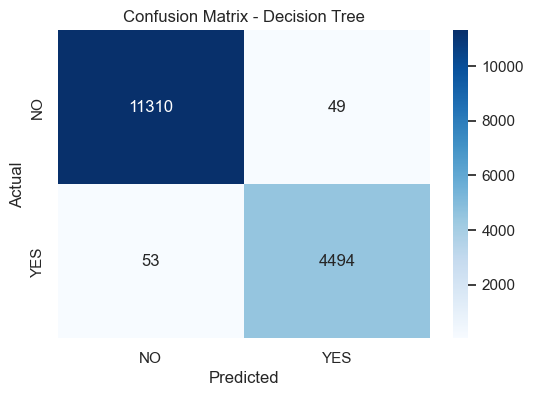

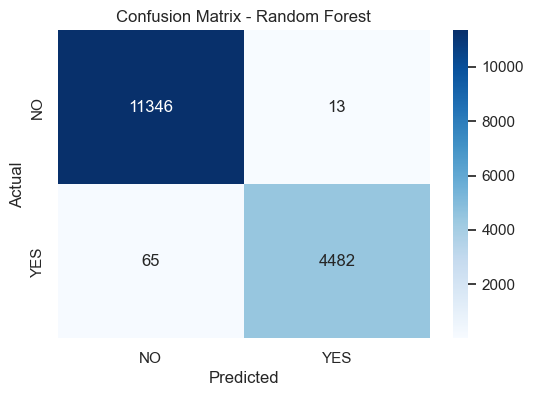

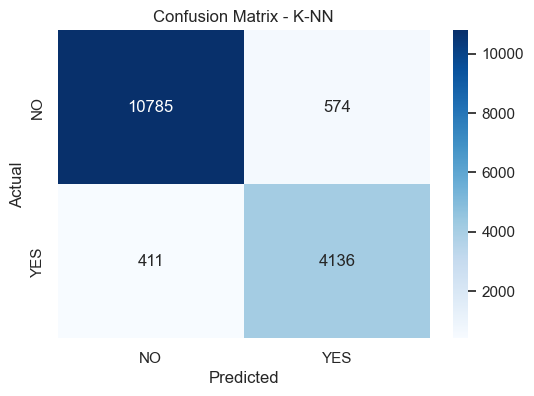

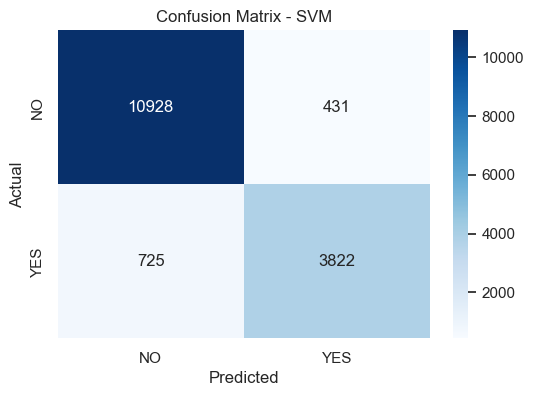

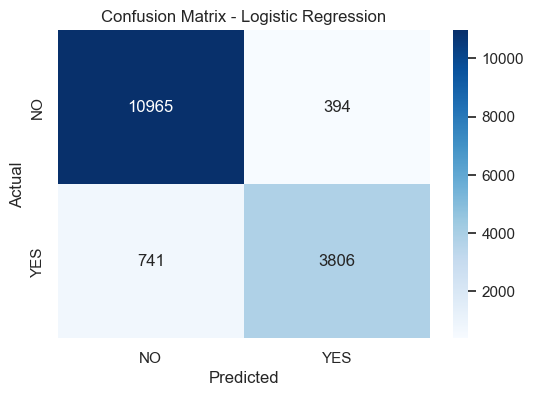

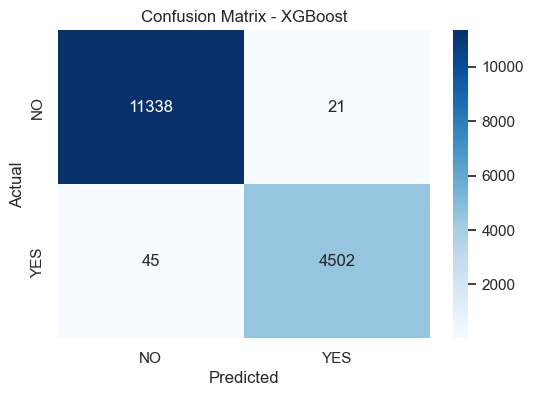

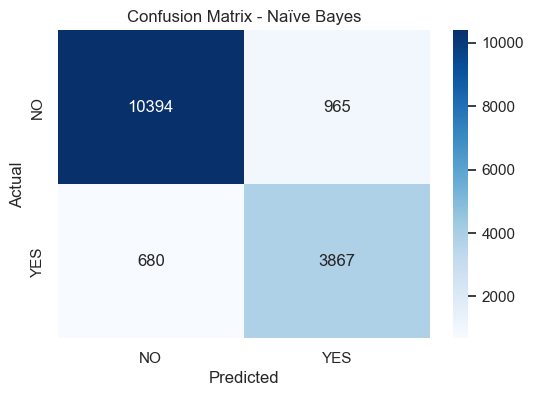

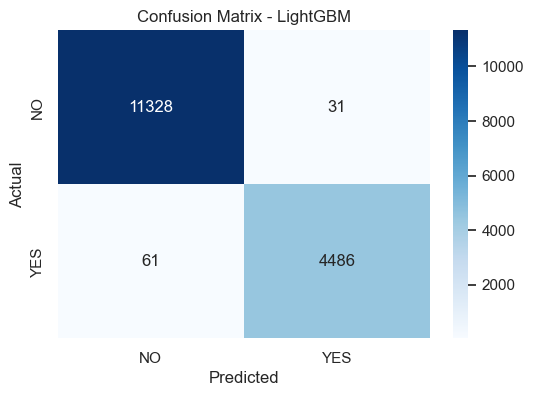

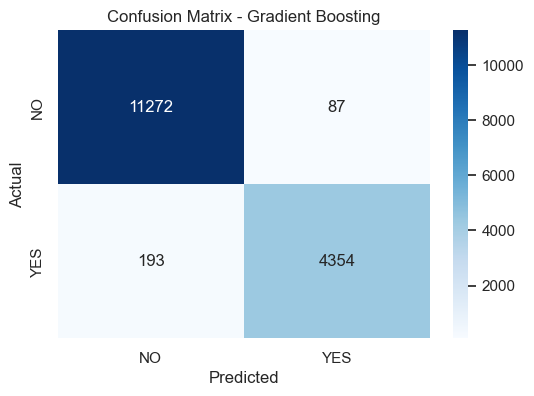

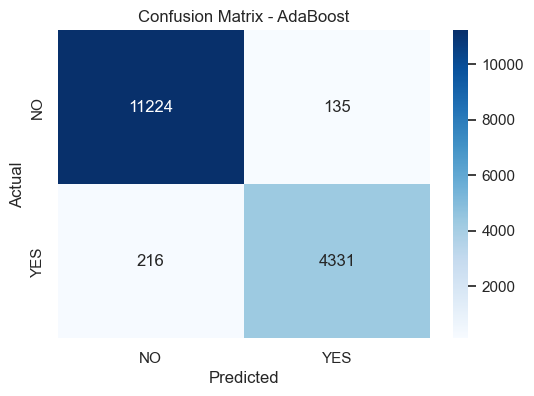

In [462]:
# Generate confusion matrices for all models
for name, file in zip(model_names, model_files):
    model = joblib.load(file)
    y_pred = model.predict(X_test)
    plot_confusion_matrix(name, y_test, y_pred)

## 5.3: Feature Importance (For Tree-Based Models)

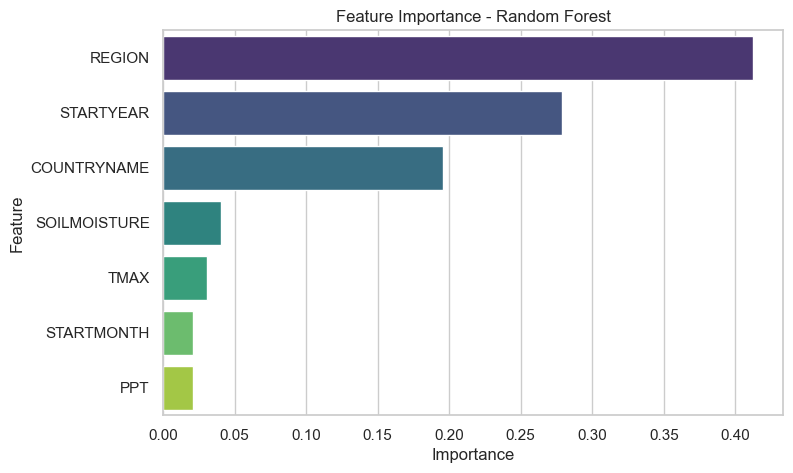

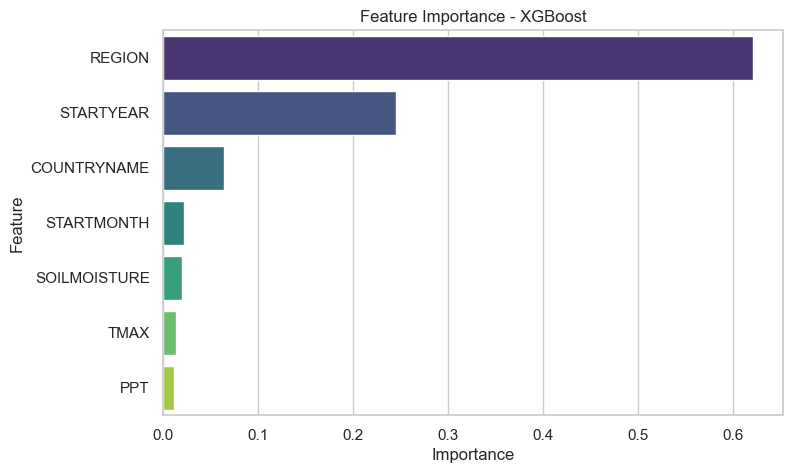

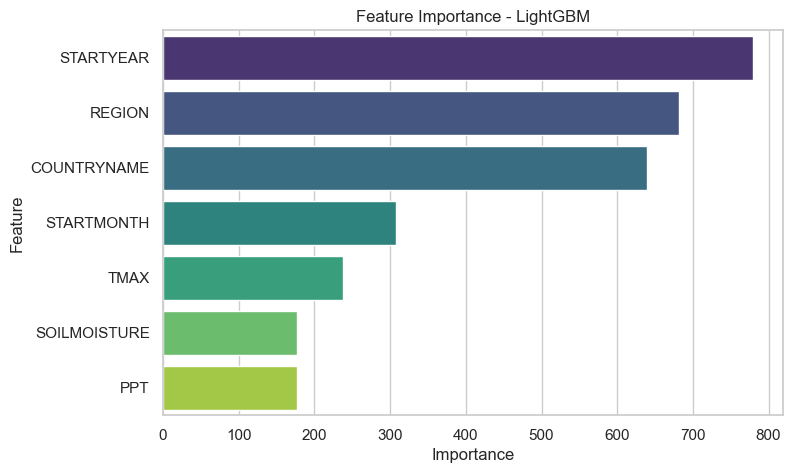

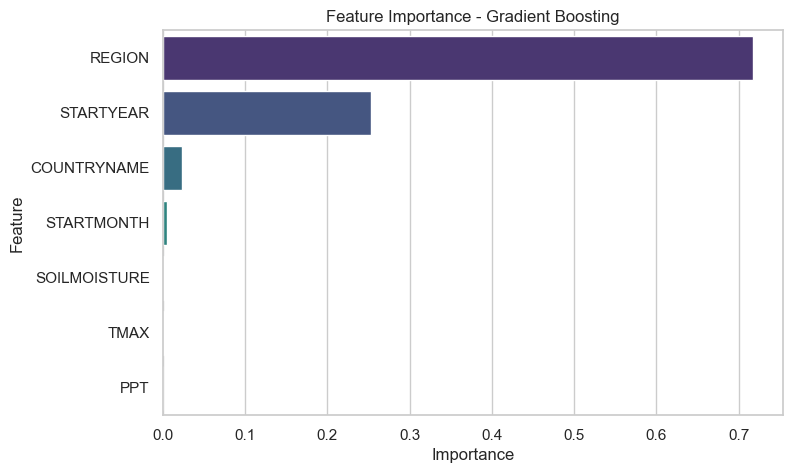

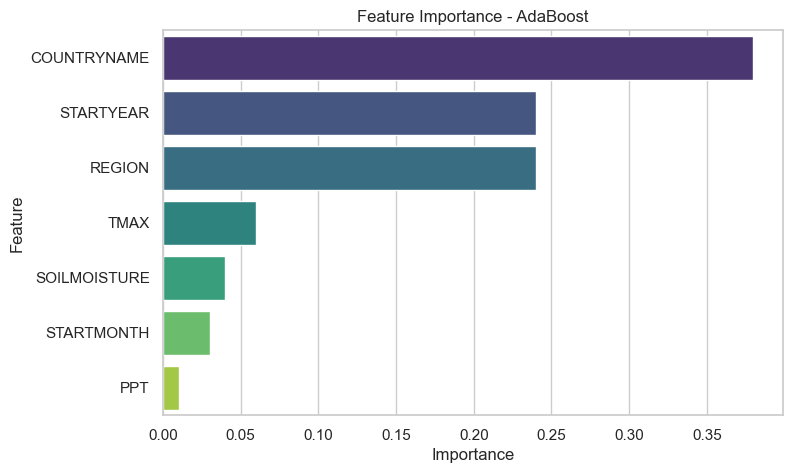

In [476]:
# Models that support feature importance
tree_based_models = ["Random Forest", "XGBoost", "LightGBM", "Gradient Boosting", "AdaBoost"]
feature_names = X_train.columns

for name, file in zip(model_names, model_files):
    if name in tree_based_models:
        model = joblib.load(file)
        
        # Extract feature importance
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            sorted_idx = np.argsort(importances)[::-1]

            plt.figure(figsize=(8,5))
            sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx], palette="viridis")
            plt.title(f"Feature Importance - {name}")
            plt.xlabel("Importance")
            plt.ylabel("Feature")
            plt.show()


# 6.0: Hyperparameter Tuning

## 6.1: Random Forest 

In [ ]:
# Define hyperparameter grid
rf_params = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# Perform Randomized Search
rf_search = RandomizedSearchCV(rf_model, rf_params, n_iter=10, cv=5, scoring="accuracy", n_jobs=-1, verbose=2, random_state=42)
rf_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for Random Forest:", rf_search.best_params_)
print("Best Accuracy:", rf_search.best_score_)

# Save the best model
joblib.dump(rf_search.best_estimator_, "../models/random_forest_tuned.pkl")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


## 6.2: XGBoost

In [ ]:
# Define hyperparameter grid
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10]
}

# Initialize model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Perform Randomized Search
xgb_search = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, cv=5, scoring="accuracy", n_jobs=-1, verbose=2, random_state=42)
xgb_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for XGBoost:", xgb_search.best_params_)
print("Best Accuracy:", xgb_search.best_score_)

# Save the best model
joblib.dump(xgb_search.best_estimator_, "../models/xgboost_tuned.pkl")

## 6.3: LightGBM

In [ ]:
# Define hyperparameter grid
lgb_params = {
    "num_leaves": [20, 31, 50, 100],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200, 300, 500]
}

# Initialize model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Perform Randomized Search
lgb_search = RandomizedSearchCV(lgb_model, lgb_params, n_iter=10, cv=5, scoring="accuracy", n_jobs=-1, verbose=2, random_state=42)
lgb_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for LightGBM:", lgb_search.best_params_)
print("Best Accuracy:", lgb_search.best_score_)

# Save the best model
joblib.dump(lgb_search.best_estimator_, "../models/lightgbm_tuned.pkl")

## 6.4: Gradient Boosting

In [ ]:
# Define hyperparameter grid
gb_params = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10]
}

# Initialize model
gb_model = GradientBoostingClassifier(random_state=42)

# Perform Randomized Search
gb_search = RandomizedSearchCV(gb_model, gb_params, n_iter=10, cv=5, scoring="accuracy", n_jobs=-1, verbose=2, random_state=42)
gb_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for Gradient Boosting:", gb_search.best_params_)
print("Best Accuracy:", gb_search.best_score_)

# Save the best model
joblib.dump(gb_search.best_estimator_, "../models/gradient_boosting_tuned.pkl")

## 6.5: SVM

In [ ]:
# Define hyperparameter grid
svm_params = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.01, 0.1, 1, "scale"],
    "kernel": ["rbf", "linear"]
}

# Initialize model
svm_model = SVC(probability=True, random_state=42)

# Perform Randomized Search
svm_search = RandomizedSearchCV(svm_model, svm_params, n_iter=10, cv=5, scoring="accuracy", n_jobs=-1, verbose=2, random_state=42)
svm_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for SVM:", svm_search.best_params_)
print("Best Accuracy:", svm_search.best_score_)

# Save the best model
joblib.dump(svm_search.best_estimator_, "../models/svm_tuned.pkl")